<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/15_Transformer_emotion_recognizer_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20240329)

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, losses, optimizers

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

In [3]:
from datasets import load_dataset
emotions = load_dataset('emotion')

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

VOCAB_SIZE

30522

In [5]:
MAX_LEN = 128

# Training set
train_set = tokenizer(emotions['train']['text'], max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_mask = np.array(train_set['attention_mask'])
train_label = np.eye(6)[emotions['train']['label']]

# Test set
test_set = tokenizer(emotions['validation']['text'], max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_mask = np.array(test_set['attention_mask'])
test_label = np.eye(6)[emotions['validation']['label']]

emotion_labels = emotions['train'].features['label'].names

In [6]:
class Embeddings(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(Embeddings, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=max_len,
                                        output_dim=embed_dim)
        self.dropout = layers.Dropout(rate=0.5)
        self.ln = layers.LayerNormalization(epsilon=1e-12)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        position_ids = tf.range(start=0, limit=seq_len, delta=1)
        position_embeddings = self.pos_emb(position_ids)

        token_embeddings = self.token_emb(inputs)
        embeddings = token_embeddings + position_embeddings # Add position embeddings

        embeddings = self.ln(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [7]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(rate=0.1)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation='relu')
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(rate=0.1)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, masks):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        attention_mask = tf.reshape(
            tf.tile(masks, [1, seq_len]), [batch_size, seq_len, seq_len])
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=attention_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        attention_output =  attention_output + inputs # Skip connection
        attention_output = self.ln_1(attention_output)

        ffn_1 = self.ffn_1(attention_output)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)

        ffn_output = ffn_output + attention_output # Skip connection
        ffn_output = self.ln_2(ffn_output)
        return (ffn_output, attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
            }
        )
        return config

In [8]:
EMBEDDING_DIM = 512
N_HEADS = 8
KEY_DIM = EMBEDDING_DIM // N_HEADS
FEED_FORWARD_DIM = 2048

text_inputs = layers.Input(shape=(None,), dtype=tf.int32)
mask_inputs = layers.Input(shape=(None,), dtype=tf.int32)

x = Embeddings(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(text_inputs)
x, attention_scores1 = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM)(x, mask_inputs)
x, attention_scores2 = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM)(x, mask_inputs)
output = layers.Dense(6, activation='softmax')(x[:, 0, :]) # select [CLS] token

# Model for training and prediction
transformer_model = models.Model(
    inputs=[text_inputs, mask_inputs], outputs=output)

# Model for retrieving attention scores
attention_scores_model = models.Model(
    inputs=[text_inputs, mask_inputs],
    outputs=[attention_scores1, attention_scores2])

transformer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embeddings (Embeddings)        (None, None, 512)    15693824    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 transformer_block (Transformer  ((None, None, 512),  3152384    ['embeddings[0][0]',             
 Block)                          (None, 8, None, No               'input_2[0][0]']            

In [9]:
transformer_model.compile(optimizer=optimizers.Adam(learning_rate=0.00005),
                          loss='categorical_crossentropy',
                          metrics=['acc'])

In [10]:
%%time
history = transformer_model.fit([train_text, train_mask], train_label,
                                 validation_data=([test_text, test_mask], test_label),
                                 batch_size=32, epochs=8)

Epoch 1/8
500/500 [==============================] - 88s 140ms/step - loss: 1.6641 - acc: 0.3286 - val_loss: 1.4192 - val_acc: 0.4495
Epoch 2/8
500/500 [==============================] - 42s 85ms/step - loss: 0.8367 - acc: 0.7103 - val_loss: 0.3758 - val_acc: 0.8780
Epoch 3/8
500/500 [==============================] - 37s 74ms/step - loss: 0.4110 - acc: 0.8584 - val_loss: 0.2852 - val_acc: 0.8955
Epoch 4/8
500/500 [==============================] - 37s 75ms/step - loss: 0.3182 - acc: 0.8866 - val_loss: 0.2503 - val_acc: 0.8995
Epoch 5/8
500/500 [==============================] - 37s 75ms/step - loss: 0.2697 - acc: 0.8997 - val_loss: 0.2549 - val_acc: 0.9005
Epoch 6/8
500/500 [==============================] - 36s 73ms/step - loss: 0.2314 - acc: 0.9107 - val_loss: 0.2517 - val_acc: 0.9025
Epoch 7/8
500/500 [==============================] - 37s 74ms/step - loss: 0.2107 - acc: 0.9163 - val_loss: 0.2363 - val_acc: 0.9065
Epoch 8/8
500/500 [==============================] - 38s 75ms/step -

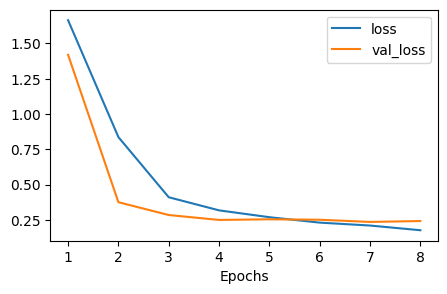

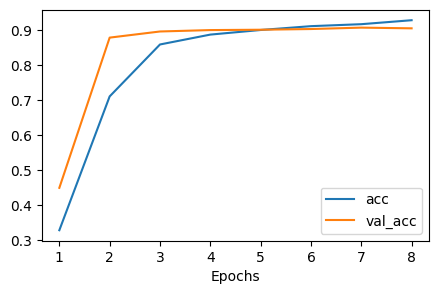

In [11]:
df = DataFrame({'loss': history.history['loss'],
               'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
               'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

In [12]:
predictions = transformer_model.predict([test_text, test_mask], verbose=0)

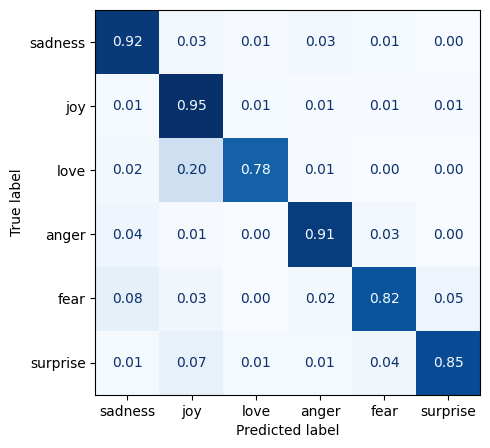

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    y_pred = np.argmax(predictions, axis=1),
    y_true = np.argmax(test_label, axis=1),
    normalize='true')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=emotions['validation'].features['label'].names)
_ = disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax)

In [14]:
input_text = [
    "I am so heartbroken that I don't know what to do.",
    "I am happy to be here with you.",
    "I'm caring about you as your mother.",
    "I'm irritated with your behavior.",
    "I'm afraid of what might happen to the people I love.",
    "I was shocked to see the broken window."]

tokenized_text = tokenizer(input_text, max_length=len(train_text[0]),
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])
mask = np.array(tokenized_text['attention_mask'])

predictions = transformer_model.predict([input_ids, mask], verbose=0)

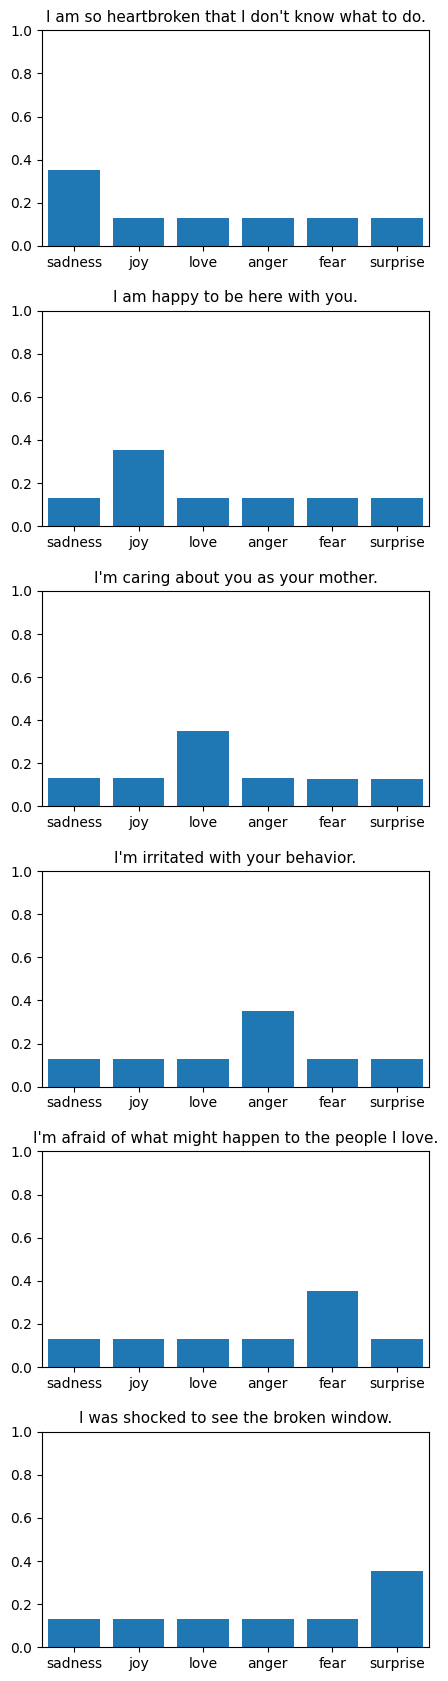

In [15]:
n = len(predictions)
fig = plt.figure(figsize=(5, 3.5 * n))
plt.subplots_adjust(hspace=0.3)

for c, pred in enumerate(predictions):
    probs = np.exp(pred)/sum(np.exp(pred))
    subplot = fig.add_subplot(n, 1, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c], fontsize=11)
    _ = subplot.bar(range(6), probs, align='center')

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
transformer_model.save('/content/gdrive/My Drive/Transformer_emotion_reconginizer.hd5', save_format='h5')
attention_scores_model.save('/content/gdrive/My Drive/Transformer_emotion_reconginizer_attention_scores.hd5', save_format='h5')

In [19]:
!ls -lh '/content/gdrive/My Drive/Transformer_emotion_reconginizer.hd5'
!ls -lh '/content/gdrive/My Drive/Transformer_emotion_reconginizer_attention_scores.hd5'

-rw------- 1 root root 252M Jul  3 21:53 '/content/gdrive/My Drive/Transformer_emotion_reconginizer.hd5'
-rw------- 1 root root 84M Jul  3 21:53 '/content/gdrive/My Drive/Transformer_emotion_reconginizer_attention_scores.hd5'
